<a href="https://colab.research.google.com/github/Keerthanarampa/BreastCancer-detection-using-DL/blob/main/temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_dir = '/content/drive/My Drive/originals'

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np


In [22]:
labels = ['benign','malignant']
img_size = 150
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [23]:
train = get_data(r"../content/drive/My Drive/originals/train")
val = get_data(r"../content/drive/My Drive/originals/validation")
test=get_data(r"../content/drive/My Drive/originals/test")

<ipython-input-22-9ed125d4ac81>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [24]:
import os
len(os.listdir("../content/drive/My Drive/originals/train/benign"))

70

<Axes: xlabel='count'>

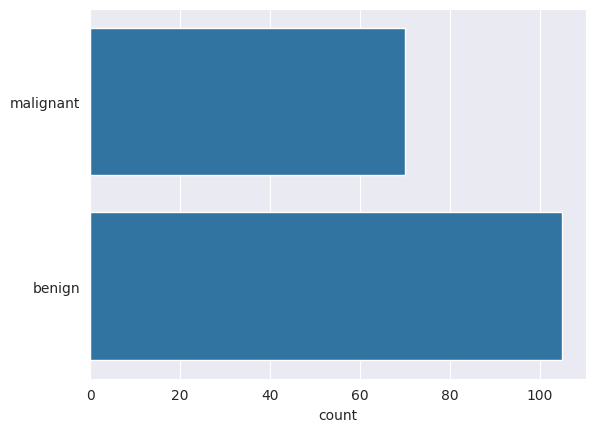

In [25]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("malignant")
    else:
        l.append("benign")
sns.set_style('darkgrid')
sns.countplot(l)

In [27]:
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

for feature, label in test:
  x_test.append(feature)
  y_test.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test=np.array(x_test)/255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)


In [28]:
print("x_train:",x_train.shape)
print("y_train:",y_train.shape)
print("x_test:",x_test.shape)
print("y_test:",y_test.shape)
print("x_val:",x_val.shape)
print("y_val:",y_val.shape)

x_train: (175, 150, 150, 3)
y_train: (175,)
x_test: (25, 150, 150, 3)
y_test: (25,)
x_val: (50, 150, 150, 3)
y_val: (50,)


In [29]:
datagen = ImageDataGenerator(
       featurewise_center=False,
       samplewise_center=False,
       featurewise_std_normalization=False,
       samplewise_std_normalization=False,
       zca_whitening=False,
       rotation_range = 90,
       zoom_range = 0.5,
       width_shift_range=0.2,
       height_shift_range=0.2,
       horizontal_flip = True,

)

datagen.fit(x_train)
datagen.fit(x_val)
datagen.fit(x_test)


In [30]:
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization,Activation
convlayer=ResNet101V2(input_shape=(150,150,3),weights='imagenet',include_top=False)
for layer in convlayer.layers:
    layer.trainable=False

In [31]:
model=Sequential()
model.add(convlayer)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(512,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 5, 5, 2048)        42626560  
                                                                 
 dropout_3 (Dropout)         (None, 5, 5, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 batch_normalization_3 (Bat  (None, 51200)             204800    
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 1024)              52429824  
                                                                 
 batch_normalization_4 (Bat  (None, 1024)              4096      
 chNormalization)                                     

In [33]:
optimizer ='adam'
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [34]:
history=model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=25,batch_size=32,shuffle=True)

Epoch 1/25
6/6 [==============================] - 22s 2s/step - loss: 0.6107 - accuracy: 0.7257 - val_loss: 1.6702 - val_accuracy: 0.6800
Epoch 2/25
6/6 [==============================] - 1s 169ms/step - loss: 0.1095 - accuracy: 0.9600 - val_loss: 5.2905 - val_accuracy: 0.6000
Epoch 3/25
6/6 [==============================] - 1s 132ms/step - loss: 0.0345 - accuracy: 0.9943 - val_loss: 4.0654 - val_accuracy: 0.6000
Epoch 4/25
6/6 [==============================] - 1s 131ms/step - loss: 0.0238 - accuracy: 0.9943 - val_loss: 2.8319 - val_accuracy: 0.6200
Epoch 5/25
6/6 [==============================] - 1s 133ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 2.4403 - val_accuracy: 0.6200
Epoch 6/25
6/6 [==============================] - 1s 132ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 2.1762 - val_accuracy: 0.6200
Epoch 7/25
6/6 [==============================] - 1s 132ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 1.8731 - val_accuracy: 0.6400
Epoch 8/25
6/6 [======

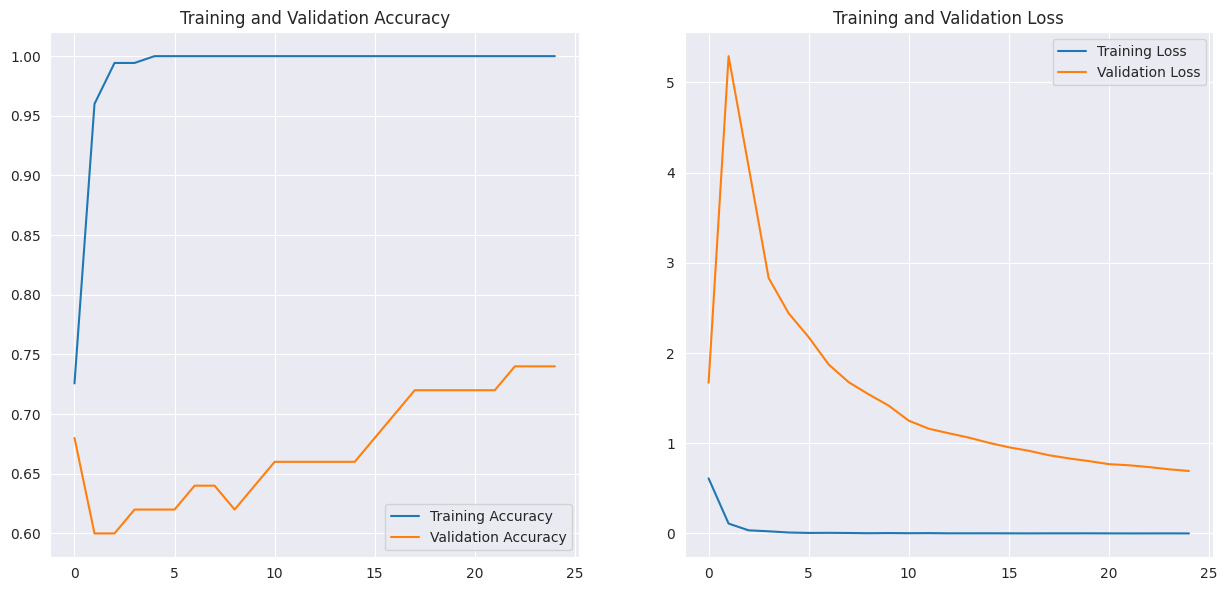

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
predictions = model.predict(x_test)
pred=np.argmax(predictions,axis=1)
pred = pred.reshape(1,-1)[0]
print(classification_report(y_test,pred, target_names = ['benign(Class 0)','malignant (Class 1)']))

1/1 [==============================] - 0s 36ms/step
                     precision    recall  f1-score   support

    benign(Class 0)       0.86      0.60      0.71        10
malignant (Class 1)       0.78      0.93      0.85        15

           accuracy                           0.80        25
          macro avg       0.82      0.77      0.78        25
       weighted avg       0.81      0.80      0.79        25



In [38]:
model.evaluate(x_test,y_test,batch_size=32)

1/1 [==============================] - 0s 230ms/step - loss: 0.9033 - accuracy: 0.8000


[0.9033456444740295, 0.800000011920929]